# Score-Matching Langevin Dynamics

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

## Langevin Dynamics using the true score function

We begin by implementing Langevin Dynamics which has theoretical guarantees as proven in the paper.

In [3]:
SAMPLES = 100
NUM_STEPS = 10000
LR = 0.01

### Implementation 1: 1D Langevin Dynamics Converging to GMM distribution
1D Gaussian mixture model with 0.5 chance being centered around 2 and 0.5 chance being centered around -2.

In [3]:
def langevin_dynamics(score, x, num_steps=NUM_STEPS, step_size=LR):
    """
    Langevin dynamics implemented as shown in Sohl-Dickstein et al. 2015
    """
    for _ in range(num_steps):
        score_x = score(x)
        x = x + 0.5 * step_size * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
        x += np.sqrt(step_size) * torch.randn_like(x)
    return x

In [4]:
def mixture_of_gaussians(x):
    """
    Score function for a mixture of two Gaussians, one at -2 and one at 2 with unit variance and equal weights.
    """
    return torch.log(0.5 * torch.exp(-0.5 * (x - 2).pow(2)) + 0.5 * torch.exp(-0.5 * (x + 2).pow(2)))

We start by sampling points uniformly and show what the effect will be when performing Langevin Dynamics on them. Note that in theory we would've needed for the prior to be with the same support as the posterior, but empirically this doesn't seem to be too important.

In [5]:
def visualize_samples(samples):
    plt.hist(samples.detach().numpy(), bins=100, density=True)
    plt.show()

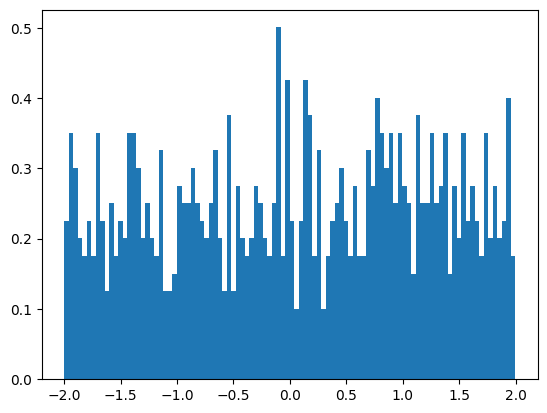

In [6]:
sample = torch.rand(1000, requires_grad=True) * 4 - 2
final = langevin_dynamics(mixture_of_gaussians, sample)
visualize_samples(sample)

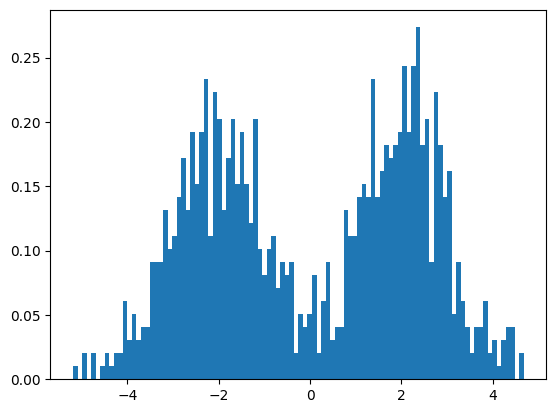

In [7]:
visualize_samples(final)

### Implementation 2: Multivariate Langevin Dynamics
2D multivariate normal, GMM with 0.5 chance of being centered at (-1, -1) and 0.5 of being centered at (1, 1). Both have low variance for them to have essentially disjoint supports.

In [8]:
def mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1):
    normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

In [9]:
sample = torch.randn(1000, 2, requires_grad=True)
mu1, sigma1 = torch.tensor([1., 1.]), 0.1
mu2, sigma2 = torch.tensor([-1., -1.]), 0.1
p1 = 0.5
final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

In [10]:
def visualize_samples2(samples):
    plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
    plt.show()

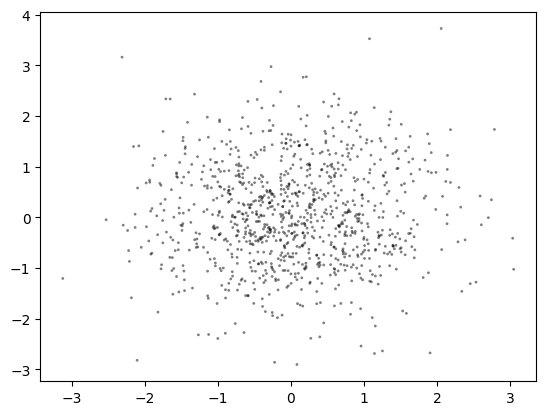

In [11]:
visualize_samples2(sample)

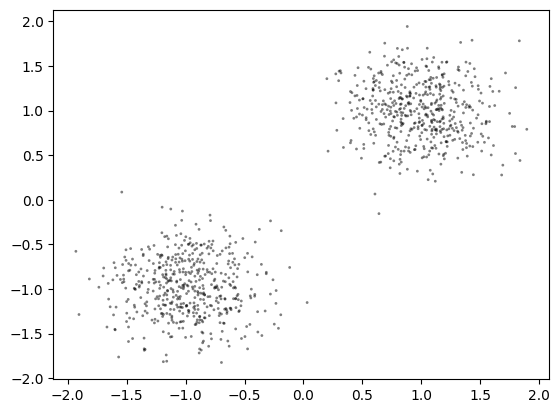

In [12]:
visualize_samples2(final)

### Implementation 3: Imbalanced GMM
What happens when the probability of being in one cluster are higher? This information is supposed to be hard to obtain in the process of taking the gradient.

In [13]:
sample = torch.randn(1000, 2, requires_grad=True)
p1 = 0.1

final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

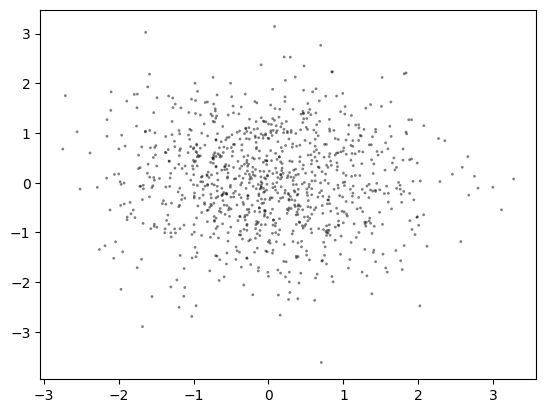

In [14]:
visualize_samples2(sample)

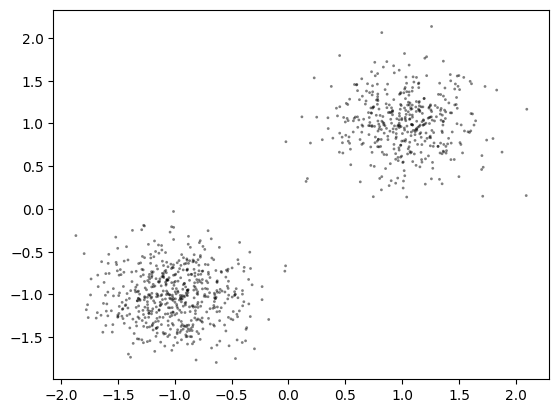

In [15]:
visualize_samples2(final)

It is still equally divided. The distribution is supposed to appear as follows:

In [16]:
true_prob = torch.rand(1000) < p1
true_prob = true_prob.float()

normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))


true_sample = torch.stack([normal1.sample() if p else normal2.sample() for p in true_prob])

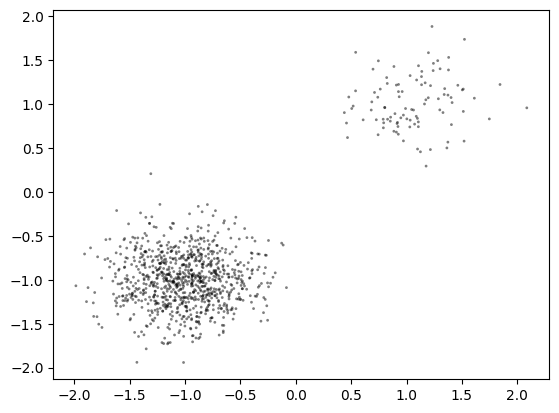

In [17]:
visualize_samples2(true_sample)

### Implementation 4: Noise Conditional Langevin Dynamics
Add decreasing noise to the data until convergence.

In [18]:
def annealed_langevin_dynamics(score, x, sigmas, num_steps=NUM_STEPS, step_size=LR):
    for sigma in sigmas:
        eps = (sigma / sigmas[-1]) ** 2 * step_size if sigma > 0 else step_size
        for _ in range(num_steps):
            score_x = score(x, sigma)
            x = x + 0.5 * eps * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
            x += np.sqrt(eps) * torch.randn_like(x)
        plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
        plt.title(f"sigma = {sigma}")
        plt.show()
    return x

In [19]:
def mixture_of_gaussians3(x, noise):
    normal1 = MultivariateNormal(mu1, (noise + sigma1) * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, (noise + sigma2) * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

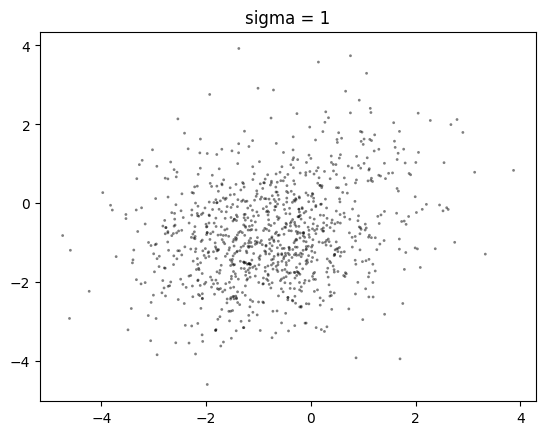

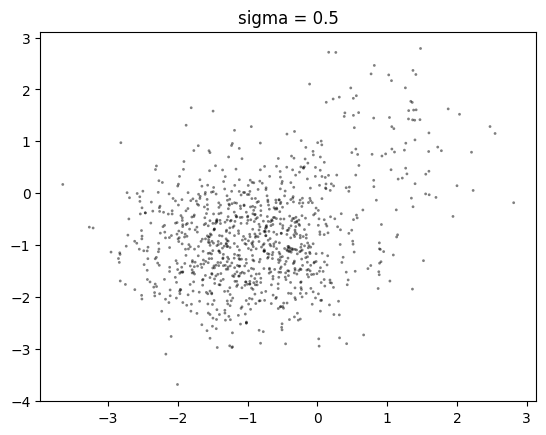

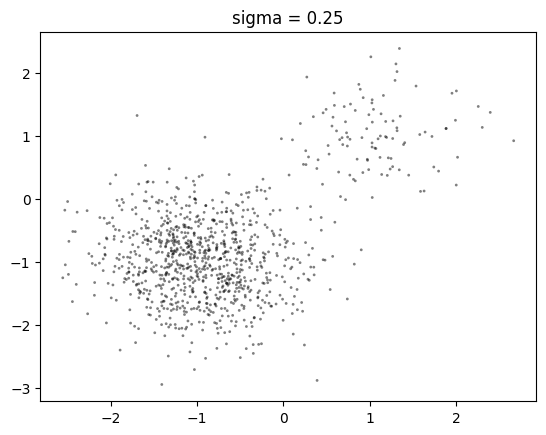

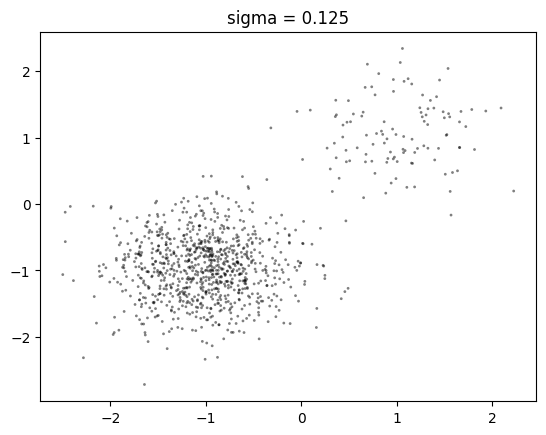

In [20]:
sample = torch.randn(1000, 2, requires_grad=True)
sigmas = [1, 0.5, 0.25, 0.125]
result = annealed_langevin_dynamics(mixture_of_gaussians3, sample, sigmas)

We can see that the annealed Langevin Dynamics do much better at estimating the distribution when it is not "even".

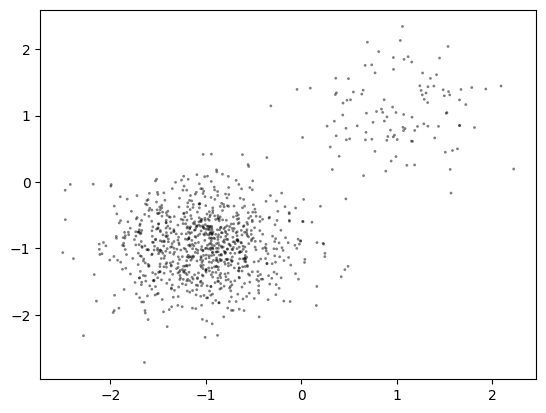

In [21]:
visualize_samples2(result)

## Langevin Dynamics using a score matcher

### Score Matching for multivariate normal

Now, we will implement a score-matching mechanism and use it to run Langevin Dynamics

We will start by implementing regular SMLD on the multivariate Gaussian, then use something more complicated for more complex distributions.

In [22]:
class FullyConnectedScoreMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FullyConnectedScoreMatcher, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def langevin_dynamics(self, x, num_steps=NUM_STEPS, step_size=LR):
        for _ in range(num_steps):
            score = self(x)
            x = x + step_size * score + torch.randn_like(x) * np.sqrt(2 * step_size)
        return x
    
    def sample(self, num_samples=1000):
        x = torch.randn(num_samples, self.input_dim)
        return self.langevin_dynamics(x)
    
    

In [23]:
train_X = torch.randn(1000, 2) * torch.sqrt(torch.tensor([0.1])) + torch.tensor([1., 1.], requires_grad=True)

# get the score function of the standard normal distribution
distribution = MultivariateNormal(torch.tensor([1.0,1.0]), 0.1 * torch.eye(2))
score = torch.autograd.grad(distribution.log_prob(train_X).sum(0), train_X)[0]

In [24]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [25]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, score)
    loss.backward()
    optimizer.step()

In [26]:
samples = model.sample(1000)

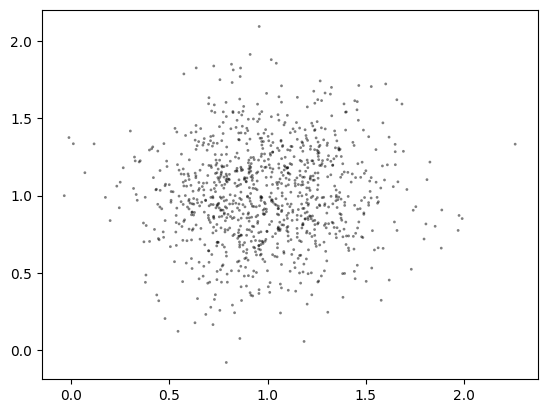

In [27]:
visualize_samples2(samples)

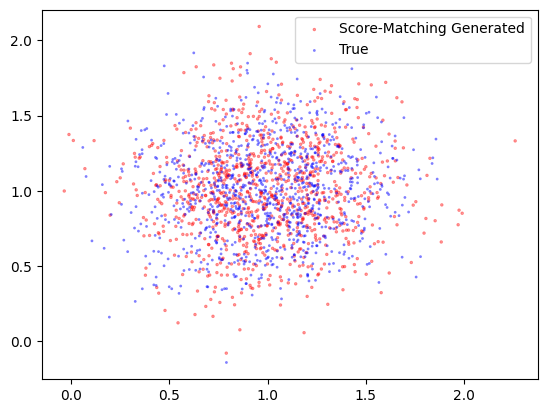

In [28]:
true_sample = distribution.sample((1000,))


plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='red', facecolors='none', alpha=0.5, s=2)
plt.scatter(true_sample[:, 0], true_sample[:, 1], edgecolors='blue', facecolors='none', alpha=0.5, s=1)
plt.legend(["Score-Matching Generated", "True"])
plt.show()

Using relatively small training data (1000 points) we were able to train a score network that can approximate the desired distribution. This is relatively easier using normal (Gaussian) distributions because they are very well-behaved. This is due to the distribution being very smooth. Distributions of images are of course much more complex, with many more variables (784 in MNIST) and much more sharp, unsmooth spikes in the density.

### Score Matching with a Mixture of Gaussians

We want to see how the score matcher will behave in cases where annealed LD might be necessary, such as regions with low density. Note that if the regions are far enough, we can ignore the influence of each region on each other in the score.

In [29]:
probabilities = torch.rand(1000) < 0.1
distribution1 = MultivariateNormal(torch.tensor([1.0,1.0]), 0.01 * torch.eye(2))
distribution2 = MultivariateNormal(torch.tensor([-1.0,-1.0]), 0.01 * torch.eye(2))

# where the probability is true, sample from the first distribution, otherwise sample from the second
score_x = lambda x, dist: torch.autograd.grad(dist.log_prob(x).sum(), x)[0]
X = torch.randn(1000, 2, requires_grad=True)
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])
sigma = 0.1

train_X = torch.stack([X[i] * sigma + mu_1 if probabilities[i] else X[i] * sigma + mu_2 for i in range(len(X))])
train_Y = torch.stack([score_x(train_X[i], distribution1) if probabilities[i] else score_x(train_X[i], distribution2) for i in range(len(train_X))])


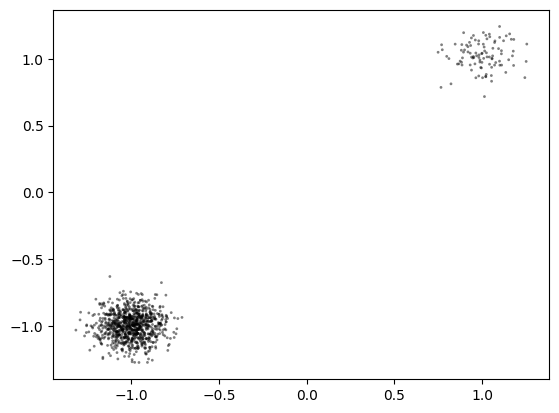

In [30]:
visualize_samples2(train_X)

In [31]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [32]:
for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, train_Y)
    loss.backward(retain_graph=True)
    optimizer.step()

Problem 1: Unable to learn the weights. I did kind of cheat by taking only the score of the respective marginal distribution instead of taking the score of the entire distribution. However the gradients would be very close to 0 anyway so I wanted to keep it simple.

In [ ]:
visualize_samples2(model.sample(1000))

Problem 2: We would expect the score at 0 to be exactly 0. However, because the likelihood of sampling 0 in the distribution is very low, it is not represented in the train data. What this means is that the score matcher will be very inaccurate in regions with low density.

Final example

In [210]:
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])
sigma = 0.1
p = 0.3

distribution1 = MultivariateNormal(mu_1, sigma * torch.eye(2))
distribution2 = MultivariateNormal(mu_2, sigma * torch.eye(2))

def density(x):
    return p * distribution1.log_prob(x).exp() + (1-p) * distribution2.log_prob(x).exp()

def true_score(x):
    return 1 / np.sqrt(sigma) * (p * distribution1.log_prob(x).exp() * (x - mu_1) + (1-p) * distribution2.log_prob(x).exp() * (x - mu_2)) / density(x)

In [214]:
train_X = torch.randn(1000, 2)
probabilities = torch.rand(1000) < p
train_X = torch.stack([train_X[i] * sigma + mu_1 if probabilities[i] else train_X[i] * sigma + mu_2 for i in range(len(train_X))])
train_Y = torch.stack([true_score(train_X[i]) for i in range(len(train_X))])

In [215]:
model = FullyConnectedScoreMatcher(2, 128)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for _ in range(1000):
    optimizer.zero_grad()
    score_pred = model(train_X)
    loss = criterion(score_pred, train_Y)
    loss.backward()
    optimizer.step()

### Score matching for MNIST images.

In this case, we need a more fit architecture, such as the U-Net. Additionally, we need to understand what the exact probability distribution is. This is what annealed LD is good for, because the distribution we have is only the empirical distribution of the train set and adding Gaussian noise to that distribution will be what smoothens the density greatly. We will be using denoising score matching, so as to make the 

UNET implementation based on open source: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, output_dim, 3, padding=1),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Downscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Downscaler, self).__init__()
        self.downscaler = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(input_dim, input_dim, output_dim)
        )

    def forward(self, x):
        return self.downscaler(x)
    

class Upscaler(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Upscaler, self).__init__()
        self.upscaler = nn.ConvTranspose2d(input_dim, output_dim, 2, stride=2)
        self.conv = DoubleConv(input_dim, input_dim, output_dim)

    def forward(self, x1, x2):
        x1 = self.upscaler(x1)
        # match dimensions of x1 and x2 by adding padding to x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(UNet, self).__init__()
        self.inc = DoubleConv(input_dim + 1, 16, 16)
        self.down1 = Downscaler(16, 32)
        self.down2 = Downscaler(32, 64)
        self.down3 = Downscaler(64, 128)
        self.up1 = Upscaler(128, 64)
        self.up2 = Upscaler(64, 32)
        self.up3 = Upscaler(32, 16)
        self.outc = nn.Conv2d(16 + 1, output_dim, 1)

    def embed_sigma(self, sigma, shape):
        return sigma.view(-1, 1, 1, 1).expand(-1, 1, shape[2], shape[3])

    def forward(self, x, sigma):
        sigma = self.embed_sigma(sigma, x.shape)
        x = torch.cat([x, sigma], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = torch.cat([x, sigma], dim=1)
        x = self.outc(x)
        return x

In [7]:
class ScoreMatchingUNet(UNet):
    def __init__(self, input_dim, output_dim, device):
        super(ScoreMatchingUNet, self).__init__(input_dim, output_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device

    def annealed_langevin_dynamics(self, x, num_steps, step_size):
        self.eval()
        with torch.no_grad():
            for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(self.device):
                eps = (sigma / 0.01) ** 2 * step_size
                sigma_tensor = torch.full((x.shape[0], 1, 1, 1), sigma).to(self.device)
                for i in range(num_steps):
                    score_x = self(x, sigma_tensor)
                    x = x + 0.5 * eps * score_x
                    x += torch.sqrt(eps) * torch.randn_like(x)
            return x.detach().cpu().numpy()

    def sample(self, num_samples=1000, height=28, width=28, num_steps=300, step_size=0.001):
        x = torch.randn(num_samples, self.input_dim, height, width).to(device)
        return self.annealed_langevin_dynamics(x, num_steps, step_size)

In [8]:
def denoising_loss(model, target, sigma):
    noise = torch.randn_like(target) * sigma
    noisy_target = target + noise
    score = model(noisy_target, sigma)
    target = -noise / (sigma ** 2)
    return 0.5 * ((score - target) ** 2).sum(dim=(1, 2, 3)).mean(dim=0)

In [9]:
model = ScoreMatchingUNet(1, 1, device)
model = model.to(device)

In [ ]:
# use MNIST as train set
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
for epoch in range(100):
    print(f"Epoch {epoch}")
    overall_loss = 0
    for i, data in enumerate(tqdm(trainloader, desc="Training"), 0):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        loss = 0
        for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device):
            sigma_tensor = torch.full((inputs.shape[0], 1, 1, 1), sigma).to(device)
            loss += denoising_loss(model, inputs, sigma_tensor) * (sigma ** 2)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        torch.save(model, f"unet_epoch{epoch}.pth")
    print(f"Loss in epoch: {overall_loss / len(trainloader)}")


Epoch 0


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.53it/s]


Loss in epoch: 369.38319165039064
Epoch 1


Training: 100%|██████████| 1875/1875 [02:44<00:00, 11.41it/s]


Loss in epoch: 354.5141614420573
Epoch 2


Training: 100%|██████████| 1875/1875 [02:44<00:00, 11.38it/s]


Loss in epoch: 346.276094140625
Epoch 3


Training: 100%|██████████| 1875/1875 [02:43<00:00, 11.47it/s]


Loss in epoch: 343.40330349934897
Epoch 4


Training: 100%|██████████| 1875/1875 [02:43<00:00, 11.49it/s]


Loss in epoch: 337.153766796875
Epoch 5


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.53it/s]


Loss in epoch: 333.01113110351565
Epoch 6


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.65it/s]


Loss in epoch: 332.15113764648436
Epoch 7


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.64it/s]


Loss in epoch: 328.3221340494792
Epoch 8


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.67it/s]


Loss in epoch: 329.8917648111979
Epoch 9


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.60it/s]


Loss in epoch: 325.21354910481773
Epoch 10


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.83it/s]


Loss in epoch: 323.67656736653646
Epoch 11


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.87it/s]


Loss in epoch: 322.66421650390623
Epoch 12


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.90it/s]


Loss in epoch: 320.7573702636719
Epoch 13


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 320.73178430989583
Epoch 14


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Loss in epoch: 318.72377652994794
Epoch 15


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.85it/s]


Loss in epoch: 317.3759927408854
Epoch 16


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.89it/s]


Loss in epoch: 318.2910658854167
Epoch 17


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.74it/s]


Loss in epoch: 316.06017049153644
Epoch 18


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.64it/s]


Loss in epoch: 315.31063784179685
Epoch 19


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.69it/s]


Loss in epoch: 314.238534765625
Epoch 20


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.67it/s]


Loss in epoch: 313.55828583984373
Epoch 21


Training: 100%|██████████| 1875/1875 [02:43<00:00, 11.49it/s]


Loss in epoch: 314.2158748372396
Epoch 22


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.65it/s]


Loss in epoch: 311.69195830078127
Epoch 23


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.59it/s]


Loss in epoch: 311.47653380533853
Epoch 24


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.58it/s]


Loss in epoch: 310.8976468424479
Epoch 25


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.51it/s]


Loss in epoch: 310.52344611002604
Epoch 26


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.52it/s]


Loss in epoch: 309.9131154622396
Epoch 27


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.59it/s]


Loss in epoch: 309.18732350260416
Epoch 28


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.59it/s]


Loss in epoch: 308.79099897460935
Epoch 29


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.65it/s]


Loss in epoch: 308.4136880859375
Epoch 30


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.73it/s]


Loss in epoch: 307.6704865397135
Epoch 31


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.58it/s]


Loss in epoch: 307.31467900390624
Epoch 32


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.62it/s]


Loss in epoch: 306.92016365559897
Epoch 33


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.77it/s]


Loss in epoch: 306.60169410807293
Epoch 34


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.75it/s]


Loss in epoch: 306.9176484863281
Epoch 35


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 305.7358060221354
Epoch 36


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.78it/s]


Loss in epoch: 305.5900381347656
Epoch 37


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.75it/s]


Loss in epoch: 305.13838776041666
Epoch 38


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.76it/s]


Loss in epoch: 304.94929368489585
Epoch 39


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.76it/s]


Loss in epoch: 304.5190280924479
Epoch 40


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.68it/s]


Loss in epoch: 304.4009504720052
Epoch 41


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.60it/s]


Loss in epoch: 304.0536010579427
Epoch 42


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.53it/s]


Loss in epoch: 304.4808211263021
Epoch 43


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.58it/s]


Loss in epoch: 303.0811092936198
Epoch 44


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.69it/s]


Loss in epoch: 303.0504249186198
Epoch 45


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.74it/s]


Loss in epoch: 303.14761027018227
Epoch 46


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.81it/s]


Loss in epoch: 302.86785232747394
Epoch 47


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.67it/s]


Loss in epoch: 302.4465424153646
Epoch 48


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.72it/s]


Loss in epoch: 302.3496668782552
Epoch 49


Training: 100%|██████████| 1875/1875 [02:42<00:00, 11.56it/s]


Loss in epoch: 302.049534375
Epoch 50


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.70it/s]


Loss in epoch: 301.908250797526
Epoch 51


Training: 100%|██████████| 1875/1875 [02:41<00:00, 11.62it/s]


Loss in epoch: 301.4941561686198
Epoch 52


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.68it/s]


Loss in epoch: 301.2510053873698
Epoch 53


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.75it/s]


Loss in epoch: 301.24768736979166
Epoch 54


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.75it/s]


Loss in epoch: 300.99582265625
Epoch 55


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.79it/s]


Loss in epoch: 300.73142866210935
Epoch 56


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.83it/s]


Loss in epoch: 300.6948376790365
Epoch 57


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.89it/s]


Loss in epoch: 300.2329817871094
Epoch 58


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.96it/s]


Loss in epoch: 300.2502450032552
Epoch 59


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.96it/s]


Loss in epoch: 300.3302592122396
Epoch 60


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.97it/s]


Loss in epoch: 299.88000608723956
Epoch 61


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.89it/s]


Loss in epoch: 299.63354300944013
Epoch 62


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.68it/s]


Loss in epoch: 299.62328203125
Epoch 63


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.71it/s]


Loss in epoch: 299.3365826822917
Epoch 64


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.70it/s]


Loss in epoch: 299.09073684895833
Epoch 65


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.80it/s]


Loss in epoch: 299.00940753580727
Epoch 66


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.88it/s]


Loss in epoch: 299.1938549967448
Epoch 67


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.81it/s]


Loss in epoch: 298.8819363932292
Epoch 68


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.72it/s]


Loss in epoch: 298.9648220214844
Epoch 69


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.74it/s]


Loss in epoch: 298.5116000813802
Epoch 70


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 298.4474653808594
Epoch 71


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Loss in epoch: 298.4024314453125
Epoch 72


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Loss in epoch: 298.47963671875
Epoch 73


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.80it/s]


Loss in epoch: 298.07033704427084
Epoch 74


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.78it/s]


Loss in epoch: 297.85830763346354
Epoch 75


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.85it/s]


Loss in epoch: 297.9624892903646
Epoch 76


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Loss in epoch: 297.62097584635416
Epoch 77


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.87it/s]


Loss in epoch: 297.5888506591797
Epoch 78


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.91it/s]


Loss in epoch: 297.4435072265625
Epoch 79


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.97it/s]


Loss in epoch: 297.44167783203125
Epoch 80


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.84it/s]


Loss in epoch: 298.43153678385414
Epoch 81


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.88it/s]


Loss in epoch: 297.0685092936198
Epoch 82


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.94it/s]


Loss in epoch: 297.3540483561198
Epoch 83


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.97it/s]


Loss in epoch: 297.1839532877604
Epoch 84


Training: 100%|██████████| 1875/1875 [02:36<00:00, 11.97it/s]


Loss in epoch: 297.08976715494794
Epoch 85


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.75it/s]


Loss in epoch: 296.9717897786458
Epoch 86


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.72it/s]


Loss in epoch: 296.8546419921875
Epoch 87


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.72it/s]


Loss in epoch: 296.80387503255207
Epoch 88


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.77it/s]


Loss in epoch: 296.51320009765624
Epoch 89


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.83it/s]


Loss in epoch: 296.586515625
Epoch 90


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.85it/s]


Loss in epoch: 296.41683284505206
Epoch 91


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.81it/s]


Loss in epoch: 296.39617763671873
Epoch 92


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 296.2513373535156
Epoch 93


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.87it/s]


Loss in epoch: 296.3789873860677
Epoch 94


Training: 100%|██████████| 1875/1875 [02:37<00:00, 11.89it/s]


Loss in epoch: 296.18839075520833
Epoch 95


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 295.88603735351563
Epoch 96


Training: 100%|██████████| 1875/1875 [02:40<00:00, 11.67it/s]


Loss in epoch: 295.88721033528645
Epoch 97


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 295.8039131673177
Epoch 98


Training: 100%|██████████| 1875/1875 [02:38<00:00, 11.82it/s]


Loss in epoch: 295.9273037109375
Epoch 99


Training: 100%|██████████| 1875/1875 [02:39<00:00, 11.78it/s]

Loss in epoch: 295.73074669596355


In [15]:
torch.save(model, 'final_model.pth')

In [ ]:
sample = model.sample(8)

In [16]:
plt.imshow(sample[1,0], cmap="gray")

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def annealed_langevin_dynamics(self, x, num_steps, step_size):
    for sigma in torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(self.device):
        eps = (sigma / 0.01) ** 2 * step_size
        sigma_tensor = torch.full((x.shape[0], 1, 1, 1), sigma).to(self.device)
        for i in range(num_steps):
            score_x = self(x, sigma_tensor)
            x = x + 0.5 * eps * score_x
            x += torch.sqrt(eps) * torch.randn_like(x)
    return x.detach().cpu().numpy()

def sample(self, num_samples=1000, height=28, width=28, num_steps=300, step_size=0.001):
    x = torch.randn(num_samples, self.input_dim, height, width).to(device)
    return annealed_langevin_dynamics(self, x, num_steps, step_size)

In [ ]:
sample(model, 1)